Imports and General Setup

In [8]:


# Some standard pythonic imports
import warnings
warnings.filterwarnings('ignore')
import logging
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
from tqdm import tqdm
import json

# MNE library for EEG data analysis
import mne
from mne import Epochs,find_events
from mne.decoding import Vectorizer
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.preprocessing import ICA

from autoreject import AutoReject

# XDF file format support in MNE
import pyxdf
from mne_import_xdf import *

# Scikit-learn and Pyriemann for feature extraction and machine learning functionalities
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score,train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, train_test_split
from pyriemann.estimation import ERPCovariances, XdawnCovariances, Xdawn, Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

#import moab to get the filterbank implementation: 
from moabb.pipelines.utils import FilterBank

# For  GUI elements
from easygui import *

# For path manipulation
import pathlib
from os import listdir
from os.path import isfile, join

# For interactive plots
import PyQt5
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt')

#imports for precision_recall_curve related plot: 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, precision_recall_curve,PrecisionRecallDisplay
from itertools import cycle
import matplotlib.pyplot as plt
import pickle

import copy


from braindecode.models import ShallowFBCSPNet
from braindecode.datautil import create_from_mne_epochs
from braindecode.training import CroppedLoss
from braindecode.training.scoring import trial_preds_from_window_preds
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch


from preprocessing import *
from training import *
from evaluation import *

# Define paths for data storage and processing
current_path = pathlib.Path().absolute()  
recording_path = current_path / 'Recordings'
figure_outputs_path=current_path / 'Figures'

#extract all recorded files and subject names
recording_files = [f for f in listdir(recording_path) if isfile(join(recording_path, f)) and ('.xdf' in f)]
if not(figure_outputs_path.exists()):
    print('the output folder does not exists:  ',figure_outputs_path)


print('all available recording files',recording_files)
subject_names=[r.split('_')[0] for r in recording_files]
print('only subjects IDS:',subject_names)

# Initial definitions: 

print('filenames:\n',recording_files)
print('names:\n',subject_names)


#define the electrode groups: the key can be anything, the values should be a list of electrodes
Electorde_Groups = {'FP': ['Fp1', 'Fp2'],
                   'AF': ['AF7', 'AF3', 'AFz', 'AF4', 'AF8'],
                   'F' : ['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8'],
                   'FC': ['FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6'],
                   'C' : ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4' ,'C6'],
                   'CP': ['CP5', 'CP3','CP1', 'CPz', 'CP2', 'CP4', 'CP6'],
                   'P' : ['P7','P5','P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8'],
                   'PO': ['PO7','PO3', 'POz', 'PO4', 'PO8'],
                   'O' : ['Oz', 'O2', 'O1', 'Iz']
                  } 

c:\Users\CensorLab\anaconda3\envs\BCIEnvironment\lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


all available recording files ['Gilad_3rdArm_0804_1.xdf', 'Gilad_3rdArm_0804_2.xdf', 'Gilad_3rdArm_0804_4.xdf', 'Gilad_3rdArm_0804_5.xdf', 'Noam_3rdArm_0104_1.xdf', 'Noam_3rdArm_0104_2.xdf', 'Noam_3rdArm_0104_3.xdf', 'Noam_3rdArm_0104_4.xdf']
only subjects IDS: ['Gilad', 'Gilad', 'Gilad', 'Gilad', 'Noam', 'Noam', 'Noam', 'Noam']
filenames:
 ['Gilad_3rdArm_0804_1.xdf', 'Gilad_3rdArm_0804_2.xdf', 'Gilad_3rdArm_0804_4.xdf', 'Gilad_3rdArm_0804_5.xdf', 'Noam_3rdArm_0104_1.xdf', 'Noam_3rdArm_0104_2.xdf', 'Noam_3rdArm_0104_3.xdf', 'Noam_3rdArm_0104_4.xdf']
names:
 ['Gilad', 'Gilad', 'Gilad', 'Gilad', 'Noam', 'Noam', 'Noam', 'Noam']


Create a parameter dictionary 

In [317]:
params_dict={}
params_dict['PerformCsd']=True
Electorde_Group_Names='F+FC+C+CP+P'
params_dict['Electorde_Group']=[] 
for cur_elec_group_name in Electorde_Group_Names.split('+'):
    params_dict['Electorde_Group']=params_dict['Electorde_Group']+Electorde_Groups[cur_elec_group_name]
params_dict['bad_electrodes'] = get_subject_bad_electrodes ('Noam') # Manually define subject name
params_dict['filter_method']='fir'
params_dict['epoch_tmins_and_maxes_grid'] = [-4,6]
params_dict['epoch_tmin'] = -4
params_dict['epoch_tmax'] = 6
params_dict['n_components']= 8
params_dict['LowPass']=8
params_dict['HighPass']=34
params_dict['filters_bands']=[[7, 12], [12, 20], [20, 28], [28, 35]]
params_dict['augmentation_params']={'win_len': 1, 'win_step': 0.1}
params_dict['classifier_window_s']=0.2
params_dict['classifier_window_e']=3
params_dict['windowed_prediction_params']={'win_len': 1, 'win_step': 0.1}
params_dict['pipeline_name']='csp+lda'
params_dict['n_components_fbcsp']=8
params_dict['desired_events'] = ['OpenPalm','Rest','ClosePalm'] 


note that no bad electrodes were defined for the current subject: Noam


Load XDF files and convert to combined mne Raw instance

In [318]:
xdf_files = [f for f in recording_path.glob('*.xdf') if 'Noam' in  f.name] # fill in name to select subject files
#OriginalRaw = Load_and_concatenate_xdf(xdf_files)
xdf_files[1:]

[WindowsPath('c:/Users/CensorLab/3rd_arm_MI/Recordings/Noam_3rdArm_0104_2.xdf'),
 WindowsPath('c:/Users/CensorLab/3rd_arm_MI/Recordings/Noam_3rdArm_0104_3.xdf'),
 WindowsPath('c:/Users/CensorLab/3rd_arm_MI/Recordings/Noam_3rdArm_0104_4.xdf')]

In [319]:
events_trigger_dict

{'ClosePalm': 3, 'OpenPalm': 5, 'Rest': 7}

In [356]:
epochs_list = []
filter_bank_epochs_list = []
movement_events = ['ClosePalm','OpenPalm'] 
for xdf_file in xdf_files[:3]:
    raw=read_raw_xdf(xdf_file)
    threshold_raw = filter_events_by_rating(raw,movement_events,rating_threshold = 4)
    epoch,filter_bank_epochs,mean_across_epochs, events_trigger_dict = EEG_Preprocessing(current_path,threshold_raw,params_dict)
    #epoch = remap_epoch_events_to_standard(epoch, standard_event_id, params_dict['desired_events'])
    # Update events_trigger_dict to match new labels
    #params_dict['events_trigger_dict'] = {event: standard_event_id[event] for event in params_dict['desired_events']}
    #events_trigger_dict = params_dict['events_trigger_dict']
    epochs_list.append(epoch)
    filter_bank_epochs_list.append(filter_bank_epochs)

print("Concatenating all preprocessed epochs...")


epochs = mne.concatenate_epochs(epochs_list, on_mismatch='warn')
filter_bank_epochs = None

Creating RawArray with float64 data, n_channels=67, n_times=333503
    Range : 0 ... 333502 =      0.000 ...   667.004 secs
Ready.

###########################################################
removing subject specific bad electrodes from the raw data

###########################################################
removing bad channels from epochs:
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.

###########################################################
filtering the data
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 34 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rating', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rating': 6, 'Rest': 7}

###########################################################
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 5001 original time points ...
1 bad epochs dropped
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm
OpenPalm
Rest
ClosePalm
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated

###########################################################
removing bad channels from epochs:
Creating RawArray with float64 data, n_channels=67, n_times=393254
    Range : 0 .

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rating', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rating': 6, 'Rest': 7}

###########################################################
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 5001 original time points ...
1 bad epochs dropped
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm
OpenPalm
Rest
ClosePalm
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated

###########################################################
removing bad channels from epochs:
Creating RawArray with float64 data, n_channels=67, n_times=430504
    Range : 0 .

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rating', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rating': 6, 'Rest': 7}

###########################################################
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 5001 original time points ...
0 bad epochs dropped
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm
OpenPalm
Rest
ClosePalm
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated

###########################################################
removing bad channels from epochs:
Concatenating all preprocessed epochs...
Not setting metadata
226 matching events 

In [355]:
epochs

Number of events,226
Events,ClosePalm: 49OpenPalm: 51Rest: 126
Time range,-4.000 – 6.000 s
Baseline,off


In [357]:
epochs

Number of events,226
Events,ClosePalm: 49OpenPalm: 51Rest: 126
Time range,-4.000 – 6.000 s
Baseline,off


In [324]:
params_dict['events_trigger_dict']

KeyError: 'events_trigger_dict'

In [325]:
events_trigger_dict

{'ClosePalm': 3, 'OpenPalm': 5, 'Rest': 7}

In [ ]:
new_events

array([[   7098,       0,       5],
       [  12978,       0,       5],
       [  23378,       0,       5],
       [  29144,       0,       5],
       [  32352,       0,       3],
       [  36327,       0,       5],
       [  39556,       0,       2],
       [  43194,       0,       5],
       [  46352,       0,       2],
       [  49693,       0,       5],
       [  53010,       0,       2],
       [  56256,       0,       5],
       [  59469,       0,       3],
       [  62668,       0,       5],
       [  65951,       0,       3],
       [ 153093,       0,       5],
       [ 156464,       0,       3],
       [ 160177,       0,       5],
       [ 166032,       0,       5],
       [ 169197,       0,       2],
       [ 172790,       0,       5],
       [ 176057,       0,       2],
       [ 179322,       0,       5],
       [ 182564,       0,       3],
       [ 186376,       0,       5],
       [ 193326,       0,       5],
       [ 196698,       0,       2],
       [ 200131,       0,   

In [294]:
standard_event_id = {'ActiveRest': 1, 'OpenPalm': 22, 'ClosePalm': 33, 'Rating': 4,'Rest': 55}

def remap_epoch_events_to_standard(epochs, standard_event_id, desired_events):
    """
    Remap event codes to standard_event_id, keep only desired events,
    and strictly preserve the original epochs.event_id order.
    """
    # Copy the original event_id order explicitly
    original_order = [key for key in epochs.event_id if key in desired_events]

    # Create mappings from old numeric codes to labels
    val_to_label = {val: label for label, val in epochs.event_id.items()}

    # Now remap numeric codes to standard_event_id values explicitly
    new_events = epochs.events.copy()
    for i, code in enumerate(new_events[:, 2]):
        label = val_to_label[code]
        new_events[i, 2] = standard_event_id[label]

    # Update events
    epochs.events = new_events

    # Reconstruct epochs.event_id preserving the original order explicitly
    epochs.event_id = OrderedDict((label, standard_event_id[label]) for label in original_order)

    return epochs



In [352]:
params_dict['events_trigger_dict']

{'ClosePalm': 33, 'OpenPalm': 22, 'Rest': 55}

Pre-processing

In [326]:
events = epochs.events
event_dict = epochs.event_id
params_dict['events_trigger_dict'] = {key: event_dict[key] for key in event_dict.keys() if key in params_dict['desired_events']}
train_inds,validation_inds,return_dict = Split_training_validation (epochs,filter_bank_epochs, params_dict['events_trigger_dict'])
epochs_copy = epochs.copy()
returned_dict=crop_the_data(epochs_copy,train_inds,validation_inds,params_dict['classifier_window_s'],params_dict['classifier_window_e']) #two more paramters here are tmin and tmax which are not used apparently. 
train_set_data_uncropped=returned_dict['train_set_data_uncropped']
epochs_cropped=returned_dict['epochs_cropped']
train_set_data=returned_dict['train_set_data']
train_set_labels=returned_dict['train_set_labels']

validation_set_labels=returned_dict['validation_set_labels']
validation_set_data_uncropped=returned_dict['validation_set_data_uncropped']
#define cv on the data: 
cv = StratifiedShuffleSplit(5, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_cropped.get_data(),events[:,2])

#filter bank related:
if params_dict['pipeline_name']=='fbcsp+lda': 
    train_set_data_fb=[]
    train_set_data_uncropped_fb=[]
    validation_set_data_fb=[]
    validation_set_data_uncropped_fb=[]
    for filtered_data_band_epoch in preprocessing_dict['filter_bank_epochs']:
        returned_dict_temp=crop_the_data(filtered_data_band_epoch,train_inds,validation_inds, params_dict['classifier_window_s'],params_dict['classifier_window_e'])
        #extract the train set data: 
        train_set_data_uncropped_temp=returned_dict_temp['train_set_data_uncropped']
        train_set_data_temp=returned_dict_temp['train_set_data']
        train_set_data_fb.append(train_set_data_temp)
        train_set_data_uncropped_fb.append(train_set_data_uncropped_temp)
        #extract the validation set data: 
        validation_set_data_uncroped_temp=returned_dict_temp['validation_set_data_uncroped']
        validation_set_data_temp=returned_dict_temp['validation_set_data']
        validation_set_data_fb.append(validation_set_data_temp)
        validation_set_data_uncropped_fb.append(validation_set_data_uncroped_temp)
    #create a 4d matrix of train data:     
    train_set_data_4d_array= np.transpose(np.array(train_set_data_fb),(1,2,3,0))
    train_set_data_uncropped_4d_array=np.transpose(np.array(train_set_data_uncropped_fb),(1,2,3,0)) 
    train_set_data=train_set_data_4d_array
    train_set_data_uncropped=train_set_data_uncropped_4d_array
    #create a 4d matrix of validation data: 
    validation_set_data_4d_array= np.transpose(np.array(validation_set_data_fb),(1,2,3,0))
    validation_set_data_uncropped_4d_array=np.transpose(np.array(validation_set_data_uncropped_fb),(1,2,3,0)) 
    validation_set_data_uncropped=validation_set_data_uncropped_4d_array


augmented_x,augmented_y = augment_data(params_dict['augmentation_params'], train_set_data,train_set_labels,epochs.info['sfreq'])

triggers_label_dict={val:key for key,val in params_dict['events_trigger_dict'].items()} 
test_data_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in validation_set_labels])  
augmented_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in augmented_y])  

putting aside 20% of the data: trial numbers are:
 [ 64 176 173 167 225 128  12 184 190  72 157  18  71 129  59  35  83 177
 130 108  61  56  11 152  95  39  57  84 204  45 161  85 125  77  48 156
  38 143  33  91 215 219  73 200   5   9]

remaining 80% of the trials go into training for cv:
 [213 155  54  74 146  25  44 120  96 188  88 223 111 136  76   2 134 137
 132  53 141 216 197 117 203 144  97 102 224 210  98 106  37  66  21 168
 179   1  93 196 221 214 163 174 151  23 202  92 103 181 126 183 109  68
 113  99  63  82  79  65  42 189  62  60  31 185 162  94 195 142 166 182
  26 115  50 160 158 119 201 138 198  80  14  24 212  32 220  49  75 105
 164 193 104   6  36 101 172  47 112 131   4 169 123  43 222 165 135 199
 133 149  78  55 140 218 148  58  28 217  81 127  34 175 121  16   8   7
 208   3 124  22   0 209 205  29  90 154  87  70  40  41 180 139  20  19
  10  51 107 211 171 194  67  27  13 114  69  30 153 116  52 207 118  86
 147 170 192  89  15 159  46 122 100 110 191 206 

In [327]:
scores_windows,folds_confusion_matrices_per_window,w_times= run_windowed_classification_aug_cv(epochs, returned_dict['epochs_cropped'], cv_split,params_dict)

Computing rank from data with rank=None
    Using tolerance 0.064 (2.2e-16 eps * 38 dim * 7.6e+12  max singular value)
    Estimated rank (mag): 38
    MAG: rank 38 computed from 38 data channels with 0 projectors
Reducing data rank from 38 -> 38
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.066 (2.2e-16 eps * 38 dim * 7.9e+12  max singular value)
    Estimated rank (mag): 38
    MAG: rank 38 computed from 38 data channels with 0 projectors
Reducing data rank from 38 -> 38
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.18 (2.2e-16 eps * 38 dim * 2.2e+13  max singular value)
    Estimated rank (mag): 38
    MAG: rank 38 computed from 38 data channels with 0 projectors
Reducing data rank from 38 -> 38
Estimating covariance using OAS
Done.
Class order in confusion matrix: ['ClosePalm' 'OpenPalm' 'Rest']
Computing rank from data with rank=None
    Using tolerance 0.063 (2.2e-16 eps * 

Cross-Validation Evaluation 

In [328]:
plot_accuracy_over_time(scores_windows, w_times, params_dict, axes_handle=None)

In [329]:
# Define binary mapping
binary_mapping = {
    'ActiveRest': 'Idle', 
    'Rest': 'Idle', 
    'Rating': 'Idle',
    'ClosePalm': 'Motor Imagery', 
    'OpenPalm': 'Motor Imagery'
}

binary_labels = ['Idle', 'Motor Imagery']

# Process each confusion matrix per window across folds
binary_confusion_matrices_per_window = []  # will be list of length num_windows, each item is list of binary matrices across folds

# Number of windows inferred from first fold
n_windows = len(folds_confusion_matrices_per_window[0])

# Loop through each window index
for window_idx in range(n_windows):
    window_binary_matrices = []

    # Loop through folds
    for fold in folds_confusion_matrices_per_window:
        matrix, labels = fold[window_idx]

        # Map original labels to binary
        label_to_binary = [binary_mapping[label] for label in labels]

        # Initialize binary confusion matrix (2x2)
        binary_matrix = np.zeros((2, 2), dtype=int)

        # Aggregate counts into binary confusion matrix
        for i, true_label in enumerate(label_to_binary):
            for j, pred_label in enumerate(label_to_binary):
                true_idx = binary_labels.index(true_label)
                pred_idx = binary_labels.index(pred_label)
                binary_matrix[true_idx, pred_idx] += matrix[i, j]

        window_binary_matrices.append(binary_matrix)

    binary_confusion_matrices_per_window.append(window_binary_matrices)


avg_binary_confusion_per_window = [
    np.mean(matrices, axis=0) for matrices in binary_confusion_matrices_per_window]

In [330]:
def plot_average_confusion_fixed_cv(folds_conf_matrices_per_window, window_index, normalize=True):
    """
    Plot average confusion matrix across CV folds and selected time windows (multi-class).
    
    Parameters:
        folds_conf_matrices_per_window: nested list of [(conf_matrix, labels)] per window per fold.
        window_index: int, list, range, or slice — selects window(s) to average over.
        normalize: if True, normalize rows to sum to 1.
    """
    # Handle single or multiple window indices
    if isinstance(window_index, int):
        window_indices = [window_index]
    else:
        window_indices = list(window_index)

    all_matrices = []
    for fold in folds_conf_matrices_per_window:
        for w_idx in window_indices:
            cm, _ = fold[w_idx]
            all_matrices.append(cm)

    avg_matrix = np.mean(all_matrices, axis=0)
    labels = folds_conf_matrices_per_window[0][window_indices[0]][1]  # consistent labels

    if normalize:
        avg_matrix = avg_matrix / avg_matrix.sum(axis=1, keepdims=True)
        avg_matrix = np.nan_to_num(avg_matrix)

    disp = ConfusionMatrixDisplay(confusion_matrix=avg_matrix, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap='Blues', ax=ax, values_format=".2f")
    ax.set_title(f"Avg Confusion Matrix (Windows {window_indices[0]}–{window_indices[-1]})")
    plt.grid(False)
    plt.show()

plot_average_confusion_fixed_cv(folds_confusion_matrices_per_window,window_index = range(50, 81))

In [331]:
def plot_avg_binary_confusion_fixed_cv(
    avg_binary_confusion_per_window,
    window_index,
    normalize=True
):
    """
    Plot averaged binary confusion matrix over selected window indices.

    Parameters:
        avg_binary_confusion_per_window: list of 2x2 np.array confusion matrices per window (averaged across folds).
        window_index: int, list, range, or slice — selects window(s) to average over.
        normalize: if True, normalize rows to sum to 1.
    """
    if isinstance(window_index, int):
        window_indices = [window_index]
    else:
        window_indices = list(window_index)

    # Average over selected windows
    selected_matrices = [avg_binary_confusion_per_window[i] for i in window_indices]
    avg_matrix = np.mean(selected_matrices, axis=0)

    if normalize:
        avg_matrix = avg_matrix / avg_matrix.sum(axis=1, keepdims=True)
        avg_matrix = np.nan_to_num(avg_matrix)

    binary_labels = ['Idle', 'Motor Imagery']
    disp = ConfusionMatrixDisplay(confusion_matrix=avg_matrix, display_labels=binary_labels)

    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(cmap='Blues', ax=ax, values_format=".2f")
    ax.set_title(f"Avg Binary Confusion (Windows {window_indices[0]}–{window_indices[-1]})")
    plt.grid(False)
    plt.show()

# Re-run with corrected formatting
plot_avg_binary_confusion_fixed_cv(avg_binary_confusion_per_window, range(50, 81), normalize=True)


In [332]:
binary_confusion_matrices_per_window

[[array([[ 2, 24],
         [19,  1]]),
  array([[ 0, 26],
         [18,  2]]),
  array([[ 1, 25],
         [19,  1]]),
  array([[ 1, 25],
         [17,  3]]),
  array([[ 1, 25],
         [18,  2]])],
 [array([[ 2, 24],
         [18,  2]]),
  array([[ 0, 26],
         [18,  2]]),
  array([[ 1, 25],
         [19,  1]]),
  array([[ 1, 25],
         [17,  3]]),
  array([[ 1, 25],
         [18,  2]])],
 [array([[ 2, 24],
         [17,  3]]),
  array([[ 0, 26],
         [16,  4]]),
  array([[ 2, 24],
         [19,  1]]),
  array([[ 1, 25],
         [16,  4]]),
  array([[ 1, 25],
         [18,  2]])],
 [array([[ 2, 24],
         [17,  3]]),
  array([[ 0, 26],
         [16,  4]]),
  array([[ 2, 24],
         [19,  1]]),
  array([[ 1, 25],
         [17,  3]]),
  array([[ 1, 25],
         [17,  3]])],
 [array([[ 2, 24],
         [15,  5]]),
  array([[ 0, 26],
         [16,  4]]),
  array([[ 2, 24],
         [17,  3]]),
  array([[ 1, 25],
         [16,  4]]),
  array([[ 1, 25],
         [18,  2]

In [333]:
avg_binary_confusion_per_window

[array([[ 1. , 25. ],
        [18.2,  1.8]]),
 array([[ 1., 25.],
        [18.,  2.]]),
 array([[ 1.2, 24.8],
        [17.2,  2.8]]),
 array([[ 1.2, 24.8],
        [17.2,  2.8]]),
 array([[ 1.2, 24.8],
        [16.4,  3.6]]),
 array([[ 1.2, 24.8],
        [15.8,  4.2]]),
 array([[ 1.2, 24.8],
        [15.2,  4.8]]),
 array([[ 1.4, 24.6],
        [15.6,  4.4]]),
 array([[ 2.2, 23.8],
        [15.6,  4.4]]),
 array([[ 2.2, 23.8],
        [14.2,  5.8]]),
 array([[ 2.2, 23.8],
        [14. ,  6. ]]),
 array([[ 2.4, 23.6],
        [14. ,  6. ]]),
 array([[ 2.6, 23.4],
        [13.8,  6.2]]),
 array([[ 3. , 23. ],
        [13.4,  6.6]]),
 array([[ 3. , 23. ],
        [13.8,  6.2]]),
 array([[ 3.2, 22.8],
        [13.8,  6.2]]),
 array([[ 3.2, 22.8],
        [13. ,  7. ]]),
 array([[ 3. , 23. ],
        [12.8,  7.2]]),
 array([[ 3.4, 22.6],
        [12.2,  7.8]]),
 array([[ 3., 23.],
        [11.,  9.]]),
 array([[ 3., 23.],
        [11.,  9.]]),
 array([[ 1.8, 24.2],
        [11. ,  9. ]]),


Training

In [334]:
clf,csp,lda = classifier_training(augmented_x,augmented_y,params_dict, BinaryClassification = False)

Computing rank from data with rank=None
    Using tolerance 0.064 (2.2e-16 eps * 38 dim * 7.6e+12  max singular value)
    Estimated rank (mag): 38
    MAG: rank 38 computed from 38 data channels with 0 projectors
Reducing data rank from 38 -> 38
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.066 (2.2e-16 eps * 38 dim * 7.9e+12  max singular value)
    Estimated rank (mag): 38
    MAG: rank 38 computed from 38 data channels with 0 projectors
Reducing data rank from 38 -> 38
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.18 (2.2e-16 eps * 38 dim * 2.2e+13  max singular value)
    Estimated rank (mag): 38
    MAG: rank 38 computed from 38 data channels with 0 projectors
Reducing data rank from 38 -> 38
Estimating covariance using OAS
Done.


In [335]:
params_dict

{'PerformCsd': True,
 'Electorde_Group': ['F7',
  'F5',
  'F3',
  'F1',
  'Fz',
  'F2',
  'F4',
  'F6',
  'F8',
  'FC5',
  'FC3',
  'FC1',
  'FC2',
  'FC4',
  'FC6',
  'C5',
  'C3',
  'C1',
  'Cz',
  'C2',
  'C4',
  'C6',
  'CP5',
  'CP3',
  'CP1',
  'CPz',
  'CP2',
  'CP4',
  'CP6',
  'P7',
  'P5',
  'P3',
  'P1',
  'Pz',
  'P2',
  'P4',
  'P6',
  'P8'],
 'bad_electrodes': {},
 'filter_method': 'fir',
 'epoch_tmins_and_maxes_grid': [-4, 6],
 'epoch_tmin': -4,
 'epoch_tmax': 6,
 'n_components': 8,
 'LowPass': 8,
 'HighPass': 34,
 'filters_bands': [[7, 12], [12, 20], [20, 28], [28, 35]],
 'augmentation_params': {'win_len': 1, 'win_step': 0.1},
 'classifier_window_s': 0.2,
 'classifier_window_e': 3,
 'windowed_prediction_params': {'win_len': 1, 'win_step': 0.1},
 'pipeline_name': 'csp+lda',
 'n_components_fbcsp': 8,
 'desired_events': ['OpenPalm', 'Rest', 'ClosePalm'],
 'events_trigger_dict': {'ClosePalm': 33, 'OpenPalm': 22, 'Rest': 55}}

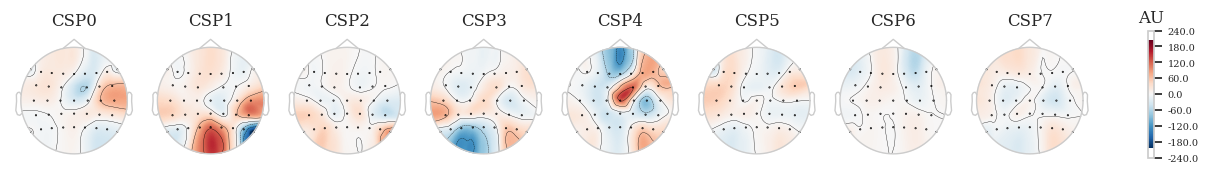

In [336]:
csp.plot_patterns(epochs.info)

In [337]:
w_length = int(raw.info['sfreq'] * params_dict['windowed_prediction_params']['win_len'])   # running classifier: window length
w_step = int(raw.info['sfreq'] * params_dict['windowed_prediction_params']['win_step'])  # running classifier: window step size
w_start = np.arange(0, train_set_data_uncropped.shape[2] - w_length, w_step)
w_times = (w_start + w_length / 2.) / raw.info['sfreq'] + params_dict['epoch_tmin']

In [338]:
scores_per_time_window,confusion_matrices_per_window = run_windowed_pretrained_classifier(clf,validation_set_data_uncropped,test_data_y_labels,w_start,w_length)


Class order in confusion matrix: ['ClosePalm' 'OpenPalm' 'Rest']


In [339]:
def plot_average_confusion_fixed(confusion_list, normalize=False, show_f1=True):
    """
    Plots the average confusion matrix from a list of confusion matrix tuples.

    Parameters:
    - confusion_list: List of tuples where each tuple is (conf_matrix: np.ndarray, labels: np.ndarray)
    - normalize: If True, normalizes each row of the average confusion matrix
    - show_f1: If True, calculates and displays macro F1 score in the title
    """
    if not confusion_list:
        raise ValueError("The confusion_list is empty.")

    # Extract confusion matrices and verify consistent labels
    conf_matrices = []
    reference_labels = confusion_list[0][1]
    for matrix, labels in confusion_list:
        if not np.array_equal(labels, reference_labels):
            raise ValueError("All confusion matrices must have the same labels in the same order.")
        conf_matrices.append(matrix)

    # Average confusion matrix
    avg_conf_matrix = np.mean(conf_matrices, axis=0)

    # Normalize if requested
    if normalize:
        norm_matrix = avg_conf_matrix / avg_conf_matrix.sum(axis=1, keepdims=True)
    else:
        norm_matrix = avg_conf_matrix

    # Simulate y_true and y_pred from avg matrix for macro F1
    if show_f1:
        y_true, y_pred = [], []
        for i in range(avg_conf_matrix.shape[0]):
            for j in range(avg_conf_matrix.shape[1]):
                y_true += [i] * int(round(avg_conf_matrix[i, j]))
                y_pred += [j] * int(round(avg_conf_matrix[i, j]))
        f1 = f1_score(y_true, y_pred, average="macro")
    else:
        f1 = None

    # Plot
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        norm_matrix,
        annot=False,
        xticklabels=reference_labels,
        yticklabels=reference_labels,
        cmap="Blues",
        cbar=True
    )

    for i in range(norm_matrix.shape[0]):
        for j in range(norm_matrix.shape[1]):
            value = norm_matrix[i, j]
            color = "black" if value < (norm_matrix.max() / 2) else "white"
            label = f"{value:.2f}"
            ax.text(j + 0.5, i + 0.5, label,
                    ha='center', va='center', color=color, fontsize=11)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    title = "Average Confusion Matrix"
    if normalize:
        title += " (Normalized)"
    if show_f1 and f1 is not None:
        title += f"\nMacro F1 Score: {f1:.2f}"
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_average_confusion_fixed(confusion_matrices_per_window[40:70], normalize=True, show_f1=True)


In [340]:

# Define binary mapping
binary_mapping = {
    'ActiveRest': 'Idle', 
    'Rest': 'Idle', 
    'Rating': 'Idle',
    'ClosePalm': 'Motor Imagery', 
    'OpenPalm': 'Motor Imagery'
}

binary_labels = ['Idle', 'Motor Imagery']

# Process each confusion matrix to create binarized confusion matrices
binary_confusion_matrices = []

for matrix, labels in confusion_matrices_per_window:
    # Map original labels to binary
    label_to_binary = [binary_mapping[label] for label in labels]

    # Initialize binary confusion matrix (2x2)
    binary_matrix = np.zeros((2, 2), dtype=int)

    # Aggregate counts into the binary confusion matrix
    for i, true_label in enumerate(label_to_binary):
        for j, pred_label in enumerate(label_to_binary):
            true_idx = binary_labels.index(true_label)
            pred_idx = binary_labels.index(pred_label)
            binary_matrix[true_idx, pred_idx] += matrix[i, j]

    binary_confusion_matrices.append(binary_matrix)

# Display binarized matrices
for idx, binary_matrix in enumerate(binary_confusion_matrices, 1):
    print(f"\nBinary Confusion Matrix for Window {idx}:\n{binary_matrix}")


Binary Confusion Matrix for Window 1:
[[ 2 24]
 [19  1]]

Binary Confusion Matrix for Window 2:
[[ 2 24]
 [18  2]]

Binary Confusion Matrix for Window 3:
[[ 2 24]
 [17  3]]

Binary Confusion Matrix for Window 4:
[[ 2 24]
 [17  3]]

Binary Confusion Matrix for Window 5:
[[ 2 24]
 [15  5]]

Binary Confusion Matrix for Window 6:
[[ 2 24]
 [16  4]]

Binary Confusion Matrix for Window 7:
[[ 2 24]
 [15  5]]

Binary Confusion Matrix for Window 8:
[[ 3 23]
 [17  3]]

Binary Confusion Matrix for Window 9:
[[ 4 22]
 [17  3]]

Binary Confusion Matrix for Window 10:
[[ 4 22]
 [15  5]]

Binary Confusion Matrix for Window 11:
[[ 4 22]
 [16  4]]

Binary Confusion Matrix for Window 12:
[[ 4 22]
 [16  4]]

Binary Confusion Matrix for Window 13:
[[ 5 21]
 [16  4]]

Binary Confusion Matrix for Window 14:
[[ 5 21]
 [15  5]]

Binary Confusion Matrix for Window 15:
[[ 5 21]
 [15  5]]

Binary Confusion Matrix for Window 16:
[[ 5 21]
 [15  5]]

Binary Confusion Matrix for Window 17:
[[ 5 21]
 [14  6]]

Binar

In [341]:
from sklearn.metrics import f1_score

def plot_avg_binary_confusion_with_metrics(conf_matrices, class_labels=["Idle", "Motor Imagery"], normalize=True):
    """
    Plots the average confusion matrix for binary classification with optional normalization and computes F1 score.

    Parameters:
    - conf_matrices: List of 2x2 confusion matrices (numpy arrays)
    - class_labels: List of two class names for labeling the axes
    - normalize: If True, rows are normalized to sum to 1 (percentage-based)
    """
    avg_conf = np.mean(conf_matrices, axis=0)

    # Normalize rows to sum to 1 (i.e., percentage over true label)
    norm_conf = avg_conf / avg_conf.sum(axis=1, keepdims=True) if normalize else avg_conf

    # Calculate F1 Score
    # Simulate predictions and true labels from averaged confusion matrix
    y_true = []
    y_pred = []
    for i in range(2):
        for j in range(2):
            y_true += [i] * int(round(avg_conf[i, j]))
            y_pred += [j] * int(round(avg_conf[i, j]))
    f1 = f1_score(y_true, y_pred, average='macro')

    # Plot heatmap
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(
        norm_conf,
        annot=False,
        xticklabels=class_labels,
        yticklabels=class_labels,
        cmap="Blues",
        cbar=True
    )

    for i in range(norm_conf.shape[0]):
        for j in range(norm_conf.shape[1]):
            value = norm_conf[i, j]
            color = "black" if value < 0.5 else "white"
            label = f"{value:.2f}" if normalize else f"{avg_conf[i, j]:.2f}"
            ax.text(j + 0.5, i + 0.5, label, ha='center', va='center', color=color, fontsize=12)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    title = "Avg Confusion Matrix (Normalized)" if normalize else "Avg Confusion Matrix"
    plt.title(f"{title}\nMacro F1 Score: {f1:.2f}")
    plt.tight_layout()
    plt.show()


# Plot the result
plot_avg_binary_confusion_with_metrics(binary_confusion_matrices[40:70])

In [342]:
binary_confusion_matrices[40:80]

[array([[23,  3],
        [ 0, 20]]),
 array([[22,  4],
        [ 0, 20]]),
 array([[22,  4],
        [ 0, 20]]),
 array([[24,  2],
        [ 0, 20]]),
 array([[24,  2],
        [ 0, 20]]),
 array([[24,  2],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[26,  0],
        [ 0, 20]]),
 array([[26,  0],
        [ 0, 20]]),
 array([[26,  0],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[25,  1],
        [ 0, 20]]),
 array([[25,

In [343]:
len(binary_confusion_matrices)

91

In [344]:
test_data_y_labels
test_data_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in validation_set_labels])  
augmented_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in augmented_y])  

In [345]:
epochs

Number of events,226
Events,ClosePalm: 49OpenPalm: 51Rest: 126
Time range,-4.000 – 6.000 s
Baseline,off


In [346]:
return_df=plot_precision_recall_curves_from_trained_classifier(train_inds,validation_inds,params_dict,precision_recall_curve_timerange=[1,2],trained_clf=clf,epochs=epochs,filter_bank_epochs=filter_bank_epochs,predict_validation=True)

chosen window prediction range is [1, 2]
note that the prediction paramaters (that the classifier is trained on) are: {'win_len': 1, 'win_step': 0.1}
consider if you want the preciction range to match the prediction_param


In [347]:
return_df

,precision_0,precision_1,precision_2,recall_0,recall_1,recall_2,thresholds0,thresholds1,thresholds2
0,0.217391,0.217391,0.565217,1.0,1.0,1.000000,-13.206673,-11.658620,-8.364188
1,0.222222,0.222222,0.577778,1.0,1.0,1.000000,-13.155473,-11.492511,-8.172550
2,0.227273,0.227273,0.590909,1.0,1.0,1.000000,-11.576341,-11.245321,-8.128914
3,0.232558,0.232558,0.581395,1.0,1.0,0.961538,-11.093792,-10.792048,-7.814287
4,0.238095,0.238095,0.595238,1.0,1.0,0.961538,-10.998854,-10.457997,-7.328052
5,0.243902,0.243902,0.609756,1.0,1.0,0.961538,-10.934291,-10.447089,-7.304142
6,0.250000,0.250000,0.625000,1.0,1.0,0.961538,-10.892373,-10.095526,-7.051019
7,0.256410,0.256410,0.641026,1.0,1.0,0.961538,-10.483671,-10.075264,-6.822867
8,0.263158,0.263158,0.657895,1.0,1.0,0.961538,-10.373902,-9.998856,-6.776063
9,0.270270,0.270270,0.675676,1.0,1.0,0.961538,-10.342154,-9.911606,-6.771383


In [348]:
return_df.to_csv('return_df.csv', index=False)


In [349]:
events = epochs.events
event_dict = epochs.event_id
params_dict['events_trigger_dict'] = {key: event_dict[key] for key in event_dict.keys() if key in params_dict['desired_events']}
train_inds,validation_inds,return_dict = Split_training_validation (epochs,filter_bank_epochs, params_dict['events_trigger_dict'])
epochs_copy = epochs.copy()
returned_dict=crop_the_data(epochs_copy,train_inds,validation_inds,params_dict['classifier_window_s'],params_dict['classifier_window_e']) #two more paramters here are tmin and tmax which are not used apparently. 
train_set_data_uncropped=returned_dict['train_set_data_uncropped']

putting aside 20% of the data: trial numbers are:
 [ 64 176 173 167 225 128  12 184 190  72 157  18  71 129  59  35  83 177
 130 108  61  56  11 152  95  39  57  84 204  45 161  85 125  77  48 156
  38 143  33  91 215 219  73 200   5   9]

remaining 80% of the trials go into training for cv:
 [213 155  54  74 146  25  44 120  96 188  88 223 111 136  76   2 134 137
 132  53 141 216 197 117 203 144  97 102 224 210  98 106  37  66  21 168
 179   1  93 196 221 214 163 174 151  23 202  92 103 181 126 183 109  68
 113  99  63  82  79  65  42 189  62  60  31 185 162  94 195 142 166 182
  26 115  50 160 158 119 201 138 198  80  14  24 212  32 220  49  75 105
 164 193 104   6  36 101 172  47 112 131   4 169 123  43 222 165 135 199
 133 149  78  55 140 218 148  58  28 217  81 127  34 175 121  16   8   7
 208   3 124  22   0 209 205  29  90 154  87  70  40  41 180 139  20  19
  10  51 107 211 171 194  67  27  13 114  69  30 153 116  52 207 118  86
 147 170 192  89  15 159  46 122 100 110 191 206 

Using matplotlib as 2D backend.


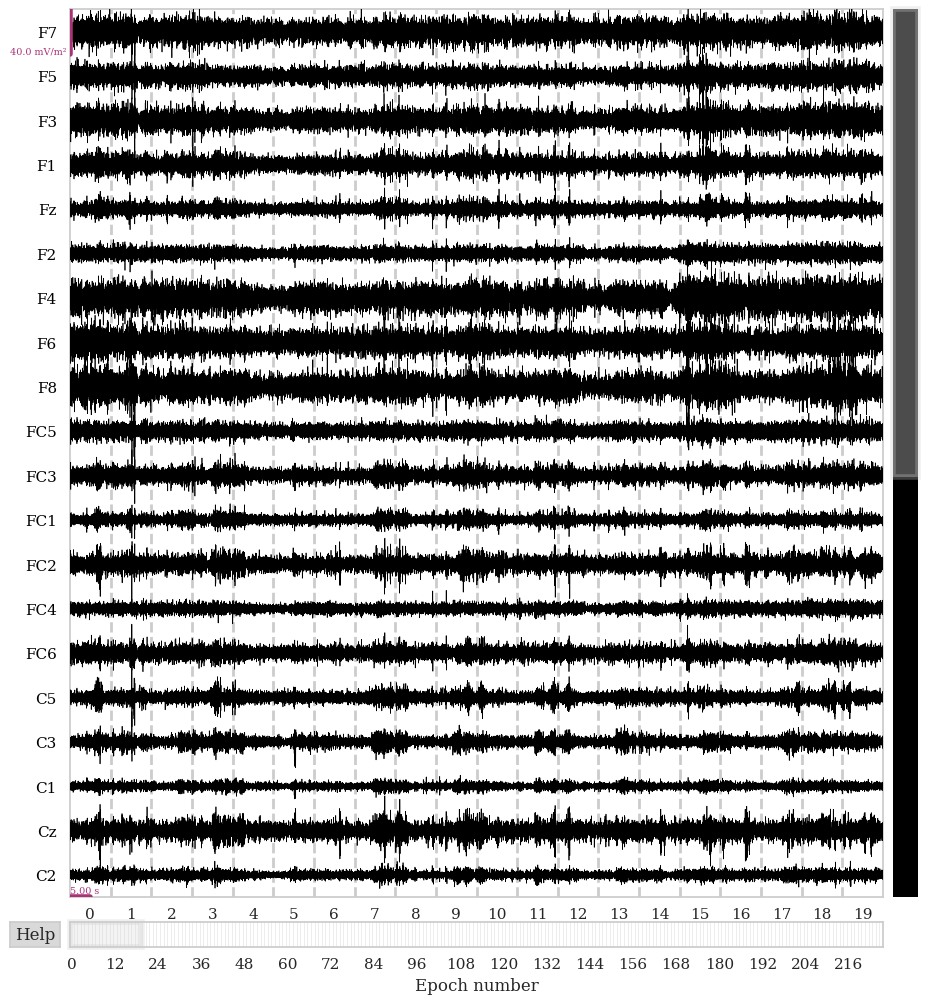

In [350]:
epochs.plot()

In [92]:
return_df=plot_binary_precision_recall_curve(train_inds,validation_inds,params_dict,precision_recall_curve_timerange=[1,2],trained_clf=clf,epochs=epochs,filter_bank_epochs=filter_bank_epochs,predict_validation=True)

Chosen window prediction range: [1, 2]
Prediction parameters: {'win_len': 1, 'win_step': 0.1}


ValueError: Found input variables with inconsistent numbers of samples: [18, 54]

In [27]:
epochs.get_data()[validation_inds, :, :].shape

(46, 20, 5001)

In [361]:
print(return_df)


    precision_0  precision_1  precision_2  precision_3  recall_0  recall_1  \
0      0.108696     0.217391     0.217391     0.456522       1.0       1.0   
1      0.111111     0.222222     0.222222     0.466667       1.0       1.0   
2      0.113636     0.227273     0.227273     0.477273       1.0       1.0   
3      0.116279     0.232558     0.232558     0.488372       1.0       1.0   
4      0.119048     0.238095     0.214286     0.500000       1.0       1.0   
5      0.121951     0.243902     0.219512     0.512195       1.0       1.0   
6      0.125000     0.250000     0.225000     0.525000       1.0       1.0   
7      0.128205     0.256410     0.230769     0.538462       1.0       1.0   
8      0.131579     0.263158     0.236842     0.552632       1.0       1.0   
9      0.135135     0.270270     0.216216     0.567568       1.0       1.0   
10     0.138889     0.277778     0.222222     0.583333       1.0       1.0   
11     0.142857     0.285714     0.228571     0.600000       1.0

In [362]:
print(return_df)


    precision_0  precision_1  precision_2  precision_3  recall_0  recall_1  \
0      0.108696     0.217391     0.217391     0.456522       1.0       1.0   
1      0.111111     0.222222     0.222222     0.466667       1.0       1.0   
2      0.113636     0.227273     0.227273     0.477273       1.0       1.0   
3      0.116279     0.232558     0.232558     0.488372       1.0       1.0   
4      0.119048     0.238095     0.214286     0.500000       1.0       1.0   
5      0.121951     0.243902     0.219512     0.512195       1.0       1.0   
6      0.125000     0.250000     0.225000     0.525000       1.0       1.0   
7      0.128205     0.256410     0.230769     0.538462       1.0       1.0   
8      0.131579     0.263158     0.236842     0.552632       1.0       1.0   
9      0.135135     0.270270     0.216216     0.567568       1.0       1.0   
10     0.138889     0.277778     0.222222     0.583333       1.0       1.0   
11     0.142857     0.285714     0.228571     0.600000       1.0

In [285]:
(np.abs(data)).shape

(20, 386020)

Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


In [295]:
def drop_noisy_segments_std(raw, n_std=5.0, min_duration=0.5):
    """
    Drop segments from CSD-transformed EEG where the signal exceeds N × STD.
    
    Parameters:
    - raw: mne.io.Raw (CSD-processed)
    - n_std: float, threshold as multiple of standard deviation
    - min_duration: float, minimum segment length (in seconds) to annotate
    
    Returns:
    - raw: mne.io.Raw with 'bad_csd' annotations
    """
    data, times = raw.get_data(return_times=True)
    
    # Global STD over all channels and time
    std = np.std(data)
    threshold = n_std * std
    
    # Mask of samples exceeding the threshold
    mask = np.any(np.abs(data) > threshold, axis=0)
    
    # Convert mask to segments
    sample_rate = raw.info['sfreq']
    bad_times = []
    in_bad = False
    for i, val in enumerate(mask):
        if val and not in_bad:
            start = i
            in_bad = True
        elif not val and in_bad:
            stop = i
            in_bad = False
            duration = (stop - start) / sample_rate
            if duration >= min_duration:
                bad_times.append((start / sample_rate, duration))
    if in_bad:
        stop = len(mask)
        duration = (stop - start) / sample_rate
        if duration >= min_duration:
            bad_times.append((start / sample_rate, duration))
    
    # Annotate as bad
    annotations = mne.Annotations(
        onset=[bt[0] for bt in bad_times],
        duration=[bt[1] for bt in bad_times],
        description=['bad_csd'] * len(bad_times)
    )
    raw.set_annotations(raw.annotations + annotations)
    return raw


In [268]:
raw

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,68 points
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


In [ ]:
cleaned_raw = drop_noisy_segments_std(raw, n_std=5.0, min_duration=0.5)
cleaned_raw

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,68 points
Good channels,20 Current source density
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,8.00 Hz
Lowpass,32.00 Hz


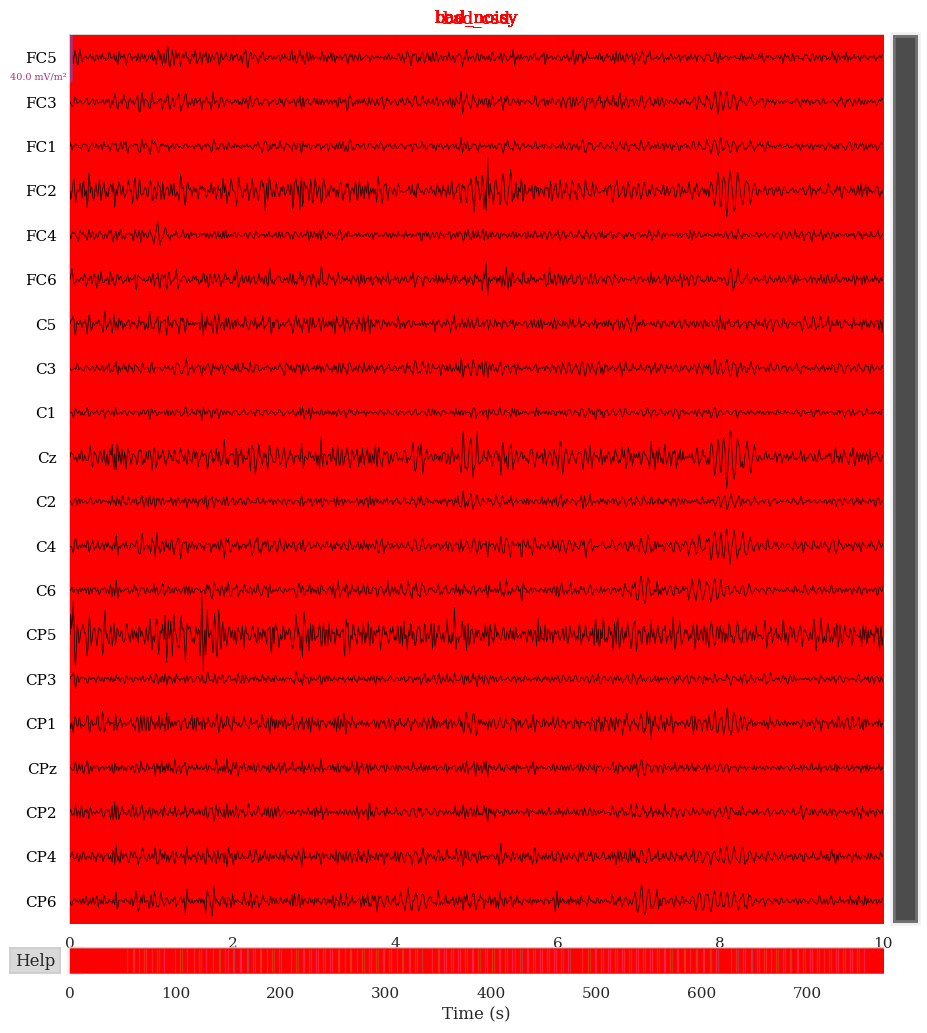

In [297]:
cleaned_raw.plot()

In [35]:

# Predict posterior probabilities
probs = clf.predict_proba(validation_set_data_uncropped[:,:,0:500])

# Set your confidence threshold
threshold = 0.4  # Adjust based on your needs

# Make predictions with 'no_decision' handling
predictions = []
for p in probs:
    if np.max(p) >= threshold:
        pred = clf.classes_[np.argmax(p)]
    else:
        pred = 'no_decision'
    predictions.append(pred)

In [163]:
from scipy.stats import entropy
# Make predictions with 'no_decision' handling

probs = clf.predict_proba(validation_set_data_uncropped[:,:,0:1000])

threshold = 0.9  # Adjust based on your needs

predictions = []
for p in probs:
    ent = entropy(p)
    if ent > threshold:
        pred = 'no_decision'
    else:
        pred = clf.classes_[np.argmax(p)]
    predictions.append(pred)


In [217]:
plot_accuracy_over_time(scores_per_time_window, w_times, params_dict, axes_handle=None)

IndexError: tuple index out of range

In [38]:
train_set_data_uncropped.shape[2] + 500- w_length

3501

In [22]:
scores_windows_array = np.squeeze(np.array(scores_per_time_window))

In [23]:
scores_windows_array.shape

(71,)

In [15]:
confusion_matrices_per_window

NameError: name 'confusion_matrices_per_window' is not defined

In [14]:
import numpy as np

def merge_conf_matrix_tuple(conf_matrix_tuple):
    """
    Converts a 4-class confusion matrix into a 2-class confusion matrix
    by merging:
    - 'ActiveRest' (0) & 'Rest' (3) → Class 0
    - 'ClosePalm' (1) & 'OpenPalm' (2) → Class 1

    Args:
    conf_matrix_tuple (tuple): (4x4 confusion matrix, class labels)

    Returns:
    tuple: (2x2 merged confusion matrix, new class labels)
    """
    cm_4class, class_labels = conf_matrix_tuple  # Extract confusion matrix & labels

    # Merge rows (true labels)
    row_0 = cm_4class[0] + cm_4class[3]  # Merge 'ActiveRest' (0) & 'Rest' (3)
    row_1 = cm_4class[1] + cm_4class[2]  # Merge 'ClosePalm' (1) & 'OpenPalm' (2)

    # Merge columns (predicted labels)
    col_0 = row_0[0] + row_0[3]  # Merge predictions for 'ActiveRest' (0) & 'Rest' (3)
    col_1 = row_0[1] + row_0[2]  # Merge predictions for 'ClosePalm' (1) & 'OpenPalm' (2)
    col_2 = row_1[0] + row_1[3]  # Merge predictions for 'ActiveRest' (0) & 'Rest' (3)
    col_3 = row_1[1] + row_1[2]  # Merge predictions for 'ClosePalm' (1) & 'OpenPalm' (2)

    # Construct new 2x2 confusion matrix
    cm_binary = np.array([
        [col_0, col_1],  # Row 0 (New Class 0)
        [col_2, col_3]   # Row 1 (New Class 1)
    ])

    return (cm_binary, np.array(['rest', 'motor_imagery']))

# Example: Apply to all confusion matrices in the list
conf_matrices_merged = [merge_conf_matrix_tuple(cm_tuple) for cm_tuple in folds_confusion_matrices_per_window]

# Print merged confusion matrices
for i, (cm_bin, labels) in enumerate(conf_matrices_merged):
    print(f"\nBinary Confusion Matrix (Window {i+1}):")
    print(cm_bin)
    print("New Labels:", labels)


ValueError: too many values to unpack (expected 2)

In [20]:
import numpy as np

def average_conf_matrix(conf_matrices_merged, start_idx, end_idx):
    """
    Computes the average confusion matrix over a given index range.

    Args:
    conf_matrices_merged (list of tuples): [(2x2 confusion matrix, labels), ...]
    start_idx (int): Start index for averaging.
    end_idx (int): End index for averaging (inclusive).

    Returns:
    tuple: (Averaged 2x2 confusion matrix, class labels)
    """
    # Extract only the confusion matrices from the selected range
    selected_matrices = [cm[0] for cm in conf_matrices_merged[start_idx:end_idx+1]]

    # Convert to numpy array and compute the mean
    avg_conf_matrix = np.mean(np.array(selected_matrices), axis=0)

    # Round values to nearest integer (optional)
    avg_conf_matrix = np.round(avg_conf_matrix).astype(int)

    # Extract class labels (assume they're the same for all matrices)
    class_labels = conf_matrices_merged[0][1]

    return avg_conf_matrix, class_labels

# Example: Compute the average confusion matrix from index 2 to 5
start_idx, end_idx = 30, 71
avg_conf_matrix, avg_labels = average_conf_matrix(conf_matrices_merged, start_idx, end_idx)

# Print result
print("\nAverage Confusion Matrix (From Index", start_idx, "to", end_idx, "):")
print(avg_conf_matrix)
print("Labels:", avg_labels)


NameError: name 'conf_matrices_merged' is not defined

In [12]:
def merge_conf_matrix_tuple(conf_matrix_tuple):
    """
    Converts a 4-class confusion matrix into a 2-class confusion matrix
    by merging:
    - 'ActiveRest' (0) & 'Rest' (3) → Class 0
    - 'ClosePalm' (1) & 'OpenPalm' (2) → Class 1

    Args:
    conf_matrix_tuple (tuple): (4x4 confusion matrix, class labels)

    Returns:
    tuple: (2x2 merged confusion matrix, new class labels)
    """
    cm_4class, class_labels = conf_matrix_tuple  # Extract confusion matrix & labels

    # Merge rows (true labels)
    row_0 = cm_4class[0] + cm_4class[3]  # Merge 'ActiveRest' (0) & 'Rest' (3)
    row_1 = cm_4class[1] + cm_4class[2]  # Merge 'ClosePalm' (1) & 'OpenPalm' (2)

    # Merge columns (predicted labels)
    col_0 = row_0[0] + row_0[3]  # Merge predictions for 'ActiveRest' (0) & 'Rest' (3)
    col_1 = row_0[1] + row_0[2]  # Merge predictions for 'ClosePalm' (1) & 'OpenPalm' (2)
    col_2 = row_1[0] + row_1[3]  # Merge predictions for 'ActiveRest' (0) & 'Rest' (3)
    col_3 = row_1[1] + row_1[2]  # Merge predictions for 'ClosePalm' (1) & 'OpenPalm' (2)

    # Construct new 2x2 confusion matrix
    cm_binary = np.array([
        [col_0, col_1],  # Row 0 (New Class 0)
        [col_2, col_3]   # Row 1 (New Class 1)
    ])

    return (cm_binary, np.array(['rest', 'motor_imagery']))

# Example: Apply to all confusion matrices in all folds
conf_matrices_merged_all_folds = [
    [merge_conf_matrix_tuple(cm_tuple) for cm_tuple in fold] for fold in folds_confusion_matrices_per_window
]

def average_conf_matrix_folds(conf_matrices_all_folds, start_idx, end_idx):
    """
    Computes the average confusion matrix over multiple folds 
    for a given index range.

    Args:
    conf_matrices_all_folds (list of list of tuples): 
        A nested list where each fold contains a list of (confusion_matrix, labels).
    start_idx (int): Start index for averaging.
    end_idx (int): End index for averaging (inclusive).

    Returns:
    tuple: (Averaged 2x2 confusion matrix, class labels)
    """
    all_selected_matrices = []  # Store matrices from all folds
    valid_folds = 0  # Count number of folds that have valid data in range

    # Iterate through each fold
    for fold in conf_matrices_all_folds:
        # Ensure the fold has enough matrices for the given index range
        if len(fold) > end_idx:
            selected_matrices = [cm_tuple[0] for cm_tuple in fold[start_idx:end_idx+1]]
            all_selected_matrices.append(np.mean(selected_matrices, axis=0))  # Average over the time window in fold
            valid_folds += 1

    # Compute final average across valid folds
    if valid_folds > 0:
        avg_conf_matrix = np.mean(np.array(all_selected_matrices), axis=0)
    else:
        print("No valid folds for the given index range!")
        return None, None

    # Round values to nearest integer (optional)
    avg_conf_matrix = np.round(avg_conf_matrix).astype(int)

    # Extract class labels (assume same for all folds)
    class_labels = conf_matrices_all_folds[0][0][1]

    return avg_conf_matrix, class_labels

# Example: Compute the average confusion matrix from index 2 to 5 across folds
start_idx, end_idx = 50,60
avg_conf_matrix, avg_labels = average_conf_matrix_folds(conf_matrices_merged_all_folds, start_idx, end_idx)
print("\nAverage Confusion Matrix (Across Folds, From Index", start_idx, "to", end_idx, "):")
print(avg_conf_matrix)
print("Labels:", avg_labels)


IndexError: index 3 is out of bounds for axis 0 with size 2

In [39]:
# Example: Compute the average confusion matrix from index 2 to 5 across folds
start_idx, end_idx = 50,70
avg_conf_matrix, avg_labels = average_conf_matrix_folds(folds_confusion_matrices_per_window, start_idx, end_idx)

# Print result
print("\nAverage Confusion Matrix (Across Folds, From Index", start_idx, "to", end_idx, "):")
print(avg_conf_matrix)

print("Labels:", avg_labels)

NameError: name 'average_conf_matrix_folds' is not defined

Sanity check on unhandled recording: 

In [81]:
xdf_files = [f for f in recording_path.glob('*.xdf') if 'Noam' in  f.name] # fill in name to select subject files
epochs_list = []
#OriginalRaw = Load_and_concatenate_xdf(xdf_files)
for xdf_file in xdf_files[3:]:
    raw=read_raw_xdf(xdf_file)
    threshold_raw = filter_events_by_rating(raw,movement_events)
    epoch,filter_bank_epochs,mean_across_epochs, events_trigger_dict = EEG_Preprocessing(current_path,threshold_raw,params_dict)
    epochs_list.append(epoch)
    filter_bank_epochs_list.append(filter_bank_epochs)

epochs = mne.concatenate_epochs(epochs_list, on_mismatch='warn')


Creating RawArray with float64 data, n_channels=67, n_times=386020
    Range : 0 ... 386019 =      0.000 ...   772.038 secs
Ready.

###########################################################
removing subject specific bad electrodes from the raw data

###########################################################
removing bad channels from epochs:
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.

###########################################################
filtering the data
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 34 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rating', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rating': 6, 'Rest': 7}

###########################################################
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 86 events and 5001 original time points ...
0 bad epochs dropped
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm
OpenPalm
Rest
ClosePalm
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated

###########################################################
removing bad channels from epochs:
Not setting metadata
86 matching events found
No baseline correction applied


In [260]:
Raw_for_analysis = raw

montage = mne.channels.read_custom_montage((f"{current_path}\Montages\CACS-64_REF.bvef"), head_size=0.095, coord_frame=None) 

Raw_for_analysis.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)
Raw_for_analysis = mne.preprocessing.compute_current_source_density(Raw_for_analysis) ## Compute CSD
Raw_for_analysis = Raw_for_analysis.filter(8, 32, method='fir')
Raw_for_analysis.pick(picks)

Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,68 points
Good channels,20 Current source density
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,8.00 Hz
Lowpass,32.00 Hz


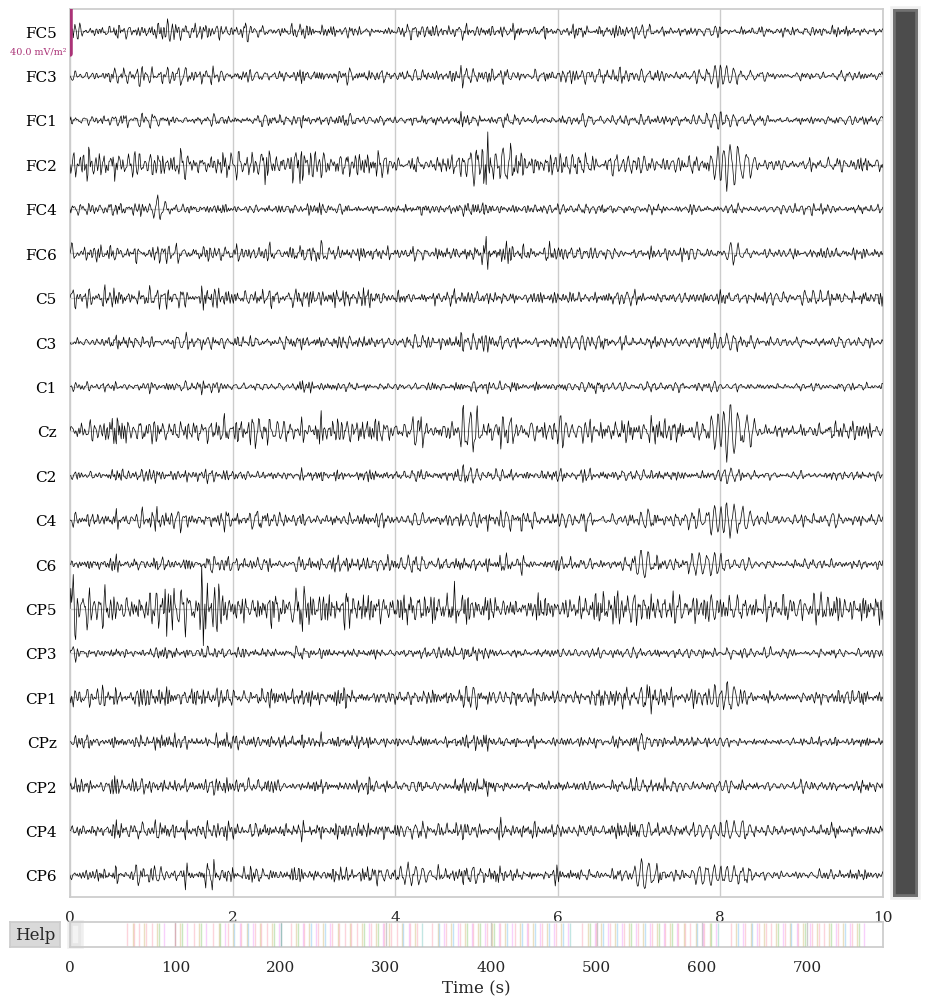

In [229]:
Raw_for_analysis.plot()

In [220]:
cropped_raw = Raw_for_analysis.copy().crop(tmax=256)


In [41]:
epochs[validation_inds]

Number of events,46
Events,ClosePalm: 10OpenPalm: 10Rest: 26
Time range,-4.000 – 6.000 s
Baseline,off


In [42]:
trained_clf=clf
#data_to_predict=(data_set_fb_4d_array[inds,:])
data_to_predict=epochs[validation_inds].copy().crop(tmin=1,tmax=2).get_data()
thresholded_prediction=trained_clf.decision_function(data_to_predict)
prediction=trained_clf.predict(data_to_predict)

#note that here you can decide on which thresholds to use to better optimize your "real" usecase
#thresholded_prediction
yhat=trained_clf.predict(data_to_predict)
lr_probs = trained_clf.predict_proba(data_to_predict)

In [30]:
thresholded_prediction

array([[-8.40912511e+00, -5.67407084e+00, -4.96676135e+00,
        -3.44587011e+00,  7.98167785e-01],
       [-1.45161873e+00, -2.35823145e+00, -2.48483634e+00,
        -2.21822171e-01, -5.45306659e+00],
       [-8.93679898e+00, -6.04436532e+00, -5.84361427e+00,
        -3.28653613e+00,  1.27381015e+00],
       [-1.93571744e+00, -2.09567764e+00, -2.28918803e+00,
        -3.97767447e-01, -5.39690459e+00],
       [-9.38897834e+00, -5.92809317e+00, -6.51326071e+00,
        -3.63189104e+00,  1.86725793e+00],
       [-3.76110325e+00, -1.67494170e+00, -2.45599031e+00,
        -6.74303700e-01, -4.90841603e+00],
       [-3.86133485e+00, -1.63784658e+00, -1.82080747e+00,
        -3.09706831e-01, -5.45313801e+00],
       [-9.28871695e+00, -9.10906648e+00, -8.44446270e+00,
        -3.78572968e+00,  3.98302964e+00],
       [-4.21887874e+00, -7.11859721e-01, -1.44211074e+00,
        -8.14900777e-01, -5.48846936e+00],
       [-3.93384954e+00, -2.34704326e+00, -2.69918303e+00,
        -2.46115761e-01

In [31]:
def binarize_labels(labels):
    binary_mapping = {
        'ActiveRest': 0,
        'Rating': 0,
        'Rest': 0,
        'OpenPalm': 1,
        'ClosePalm': 1
    }
    return np.array([binary_mapping[label] for label in labels])


def map_labels_to_strings(binary_array):
    label_mapping = {0: "Idle", 1: "Motor Imagery"}
    return np.array([label_mapping[label] for label in binary_array])

binarized_predictions = binarize_labels(prediction)
binarized_predictions = map_labels_to_strings(binarized_predictions)

In [112]:
# Threshold specifically for class 1:
threshold_class_1 = -0.561534
predictions = []
for sample in thresholded_prediction:
    if sample[1] >= threshold_class_1:
        predictions.append(1)
    else:
        # select the highest-scoring class between class 0 and class 2
        remaining_classes_scores = [sample[0], sample[2]]
        predicted_class = 0 if remaining_classes_scores[0] >= remaining_classes_scores[1] else 2
        predictions.append(predicted_class)

predictions = np.array(predictions)

# Output predictions
print(predictions)

[0 0 2 2 1 2 2 2 1 2 2 2 2 0 0 2 2 2 2 2 0 2 2 0 0 2 2 2 2 2 2 2 0 2 2 2 2
 2 2 1 2 1 2 2 2 2 2 2 2 2 2 1 2 0 2 1 2 2 2 2 2 2 2 1 2 2 2 1 1 2 1 2 2 2
 2 2 2 1 0 2 2 1 2 0 1 1 2 2 1 2]


In [116]:
threshold_1 = -0.784119
threshold_2 =  -1.251891 

predictions = []
for sample in thresholded_prediction:
    class_2_score = sample[2]
    class_1_score = sample[1]
    
    if class_2_score >= threshold_2:
        predictions.append(2)
    elif class_1_score >= threshold_1:
        predictions.append(1)
    else:
        # Choose the best between remaining classes (0 and 3)
        remaining_scores = [sample[0], sample[3]]
        predicted_class = 0 if remaining_scores[0] >= remaining_scores[1] else 3
        predictions.append(predicted_class)

predictions = np.array(predictions)
print("Predicted classes:", predictions)

Predicted classes: [0 0 3 3 2 2 2 3 2 2 2 1 2 0 0 2 2 3 3 2 3 2 2 0 3 3 3 3 3 3 2 3 0 2 3 3 3
 3 3 2 3 1 3 3 3 3 3 3 3 3 3 1 1 1 3 2 3 3 3 3 3 2 3 1 3 3 3 1 1 1 1 3 2 3
 3 3 0 1 3 1 3 2 3 0 2 1 3 3 2 3]


In [67]:
np.set_printoptions(precision=3, suppress=True)
lr_probs

array([[0.42 , 0.134, 0.446],
       [0.066, 0.029, 0.904],
       [0.05 , 0.212, 0.738],
       [0.189, 0.094, 0.717],
       [0.248, 0.072, 0.68 ],
       [0.058, 0.254, 0.688],
       [0.001, 0.049, 0.95 ],
       [0.01 , 0.166, 0.824],
       [0.071, 0.287, 0.643],
       [0.018, 0.314, 0.668],
       [0.014, 0.394, 0.592],
       [0.023, 0.248, 0.728],
       [0.025, 0.641, 0.335],
       [0.068, 0.51 , 0.422],
       [0.077, 0.074, 0.849],
       [0.244, 0.191, 0.565],
       [0.752, 0.097, 0.151],
       [0.057, 0.154, 0.789],
       [0.254, 0.053, 0.693],
       [0.607, 0.24 , 0.153],
       [0.194, 0.119, 0.687],
       [0.724, 0.027, 0.249],
       [0.603, 0.08 , 0.316],
       [0.901, 0.022, 0.077],
       [0.464, 0.104, 0.432],
       [0.221, 0.395, 0.384],
       [0.329, 0.148, 0.523],
       [0.089, 0.222, 0.689],
       [0.003, 0.243, 0.754],
       [0.137, 0.05 , 0.813],
       [0.062, 0.164, 0.774],
       [0.731, 0.038, 0.23 ],
       [0.195, 0.097, 0.709],
       [0.

In [307]:
# Get max probability among classes 1 and 2
max_prob_1_2 = np.max(lr_probs[:, 1:3], axis=1)

# Get the predicted class between class 1 and 2 (offset by +1)
argmax_1_2 = 1 + np.argmax(lr_probs[:, 1:3], axis=1)

# If confidence in class 1 or 2 >= 0.95 → choose that class, else → class 0
preds = np.where(
    max_prob_1_2 >= 0.5,
    argmax_1_2,
    0
)


In [198]:
preds = np.where(
    lr_probs[:, 0] >= 0.08,
    0,
    1 + np.argmax(lr_probs[:, 1:], axis=1)
)


In [157]:

label_map = {0: 'ActiveRest', 1: 'ClosePalm', 2: 'OpenPalm',3:'Rating'}

# Assuming `preds` is your array of predictions (from the earlier logic)
label_preds = np.vectorize(label_map.get)(predictions)

print(label_preds)

['ActiveRest' 'ActiveRest' 'Rating' 'Rating' 'OpenPalm' 'OpenPalm'
 'OpenPalm' 'Rating' 'OpenPalm' 'OpenPalm' 'OpenPalm' 'ClosePalm'
 'OpenPalm' 'ActiveRest' 'ActiveRest' 'OpenPalm' 'OpenPalm' 'Rating'
 'Rating' 'OpenPalm' 'Rating' 'OpenPalm' 'OpenPalm' 'ActiveRest' 'Rating'
 'Rating' 'Rating' 'Rating' 'Rating' 'Rating' 'OpenPalm' 'Rating'
 'ActiveRest' 'OpenPalm' 'Rating' 'Rating' 'Rating' 'Rating' 'Rating'
 'OpenPalm' 'Rating' 'ClosePalm' 'Rating' 'Rating' 'Rating' 'Rating'
 'Rating' 'Rating' 'Rating' 'Rating' 'Rating' 'ClosePalm' 'ClosePalm'
 'ClosePalm' 'Rating' 'OpenPalm' 'Rating' 'Rating' 'Rating' 'Rating'
 'Rating' 'OpenPalm' 'Rating' 'ClosePalm' 'Rating' 'Rating' 'Rating'
 'ClosePalm' 'ClosePalm' 'ClosePalm' 'ClosePalm' 'Rating' 'OpenPalm'
 'Rating' 'Rating' 'Rating' 'ActiveRest' 'ClosePalm' 'Rating' 'ClosePalm'
 'Rating' 'OpenPalm' 'Rating' 'ActiveRest' 'OpenPalm' 'ClosePalm' 'Rating'
 'Rating' 'OpenPalm' 'Rating']


In [34]:
count = np.sum(actual_events == 'ActiveRest')
print(count)  # Output: 3

10


In [32]:
prediction

array(['Rest', 'Rating', 'Rest', 'Rating', 'Rest', 'Rating', 'Rating',
       'Rest', 'ClosePalm', 'Rating', 'Rest', 'Rating', 'Rest',
       'ClosePalm', 'Rating', 'Rest', 'Rating', 'Rest', 'Rest', 'Rating',
       'Rest', 'Rest', 'OpenPalm', 'Rest', 'ClosePalm', 'Rating', 'Rest',
       'Rest', 'Rest', 'Rating', 'Rest', 'Rest', 'OpenPalm', 'Rest',
       'Rest', 'Rating', 'Rest', 'Rest', 'Rest', 'Rating', 'Rating',
       'Rest', 'Rating', 'Rest', 'Rest', 'ClosePalm', 'Rest', 'ClosePalm',
       'Rest', 'Rest', 'OpenPalm', 'Rating', 'ClosePalm', 'Rest', 'Rest',
       'Rating', 'Rest', 'Rest', 'Rating', 'Rest', 'Rest', 'Rest', 'Rest',
       'ClosePalm', 'Rest', 'Rest', 'Rating', 'Rest', 'Rest', 'OpenPalm',
       'Rest', 'Rest', 'Rest', 'Rest', 'Rest', 'ClosePalm', 'Rest',
       'Rest', 'ClosePalm', 'Rest', 'Rest', 'ClosePalm', 'Rest', 'Rest',
       'ClosePalm', 'Rest', 'Rest', 'Rating', 'Rest', 'Rest', 'Rating',
       'Rest', 'Rest', 'ClosePalm', 'Rest', 'Rest', 'Rating', 'Rest'

In [44]:
# %%

from collections import Counter

# Function to get the list of event names for each epoch
def get_epoch_events(epochs):
    events = epochs.events  # Get the array of events
    event_ids = epochs.event_id  # Get the mapping from event name to event code
    epoch_event_names = []

    for event in events:
        event_code = event[-1]  # Extract the event ID
        # Get the event name using the event code
        event_name = [key for key, val in event_ids.items() if val == event_code][0]
        epoch_event_names.append(event_name)

    return np.array(epoch_event_names)

# Function to compare actual event names with predicted event names and summarize mismatches
def compare_events(actual_events, predicted_events):
    comparison = actual_events == predicted_events  # Element-wise comparison
    accuracy = np.mean(comparison)  # Calculate accuracy
    mismatches = np.where(comparison == False)[0]  # Get indices where predictions don't match
    
    # Collect mismatched epochs and count occurrences of each mismatch case
    mismatch_details = []
    mismatch_counts = Counter()
    
    for idx in mismatches:
        actual = actual_events[idx]
        predicted = predicted_events[idx]
        mismatch_details.append(f"{idx + 1} - {actual} (actual), {predicted} (predicted)")
        mismatch_counts[f"{actual} -> {predicted}"] += 1  # Count each specific mismatch case

    return {
        'accuracy': accuracy,
        'mismatch_details': mismatch_details,
        'mismatch_counts': mismatch_counts
    }

# Example usage:
# Assume `epochs` is your mne.Epochs object, and `predictions` is the model output

actual_events = get_epoch_events(epochs[validation_inds])  # Actual events from the epochs
predicted_events = np.array(prediction)  # Replace with your model predictions

# Compare actual events to predicted events
result = compare_events(actual_events, predicted_events)

# Output the comparison result
print(f"Accuracy: {result['accuracy']:.2f}")
if result['mismatch_details']:
    print("Mismatched epochs:")
    for mismatch in result['mismatch_details']:
        print(mismatch)
    
    print("\nMismatch Summary:")
    for mismatch_case, count in result['mismatch_counts'].items():
        print(f"{mismatch_case}: {count} occurrence(s)")
else:
    print("No mismatches!")


Accuracy: 0.76
Mismatched epochs:
5 - OpenPalm (actual), ClosePalm (predicted)
7 - ClosePalm (actual), OpenPalm (predicted)
16 - OpenPalm (actual), ClosePalm (predicted)
17 - OpenPalm (actual), ClosePalm (predicted)
18 - OpenPalm (actual), ClosePalm (predicted)
26 - ClosePalm (actual), OpenPalm (predicted)
29 - Rest (actual), ClosePalm (predicted)
33 - OpenPalm (actual), ClosePalm (predicted)
39 - ClosePalm (actual), OpenPalm (predicted)
40 - ClosePalm (actual), OpenPalm (predicted)
43 - ClosePalm (actual), OpenPalm (predicted)

Mismatch Summary:
OpenPalm -> ClosePalm: 5 occurrence(s)
ClosePalm -> OpenPalm: 5 occurrence(s)
Rest -> ClosePalm: 1 occurrence(s)


In [23]:
trained_clf = clf

Save the trained model 


In [24]:
# %%

Saved_Model = trained_clf
fname = 'Gilad_3rd_arm'+'_BiCSP_model_080425'
path_fname = current_path /'Models'/ fname

#create a pickle file
picklefile = open(path_fname, 'wb')
#pickle the dictionary and write it to file
pickle.dump(Saved_Model, picklefile)
#close the file
picklefile.close()



picks=params_dict['Electorde_Group']
fname = 'electrode_picks-080425'
path_fname = current_path /'Models'/ fname

#create a pickle file
picklefile = open(path_fname, 'wb')
#pickle the dictionary and write it to file
pickle.dump(picks, picklefile)
#close the file
picklefile.close()


fname = 'mean'
path_fname = current_path /'Models'/ fname

#create a pickle file
picklefile = open(path_fname, 'wb')
#pickle the dictionary and write it to file
pickle.dump(mean_across_epochs, picklefile)
#close the file
picklefile.close()


In [279]:
raw.ch_names

['Fp1',
 'Fz',
 'F3',
 'F7',
 'FT9',
 'FC5',
 'FC1',
 'C3',
 'T7',
 'CP5',
 'CP1',
 'Pz',
 'P3',
 'P7',
 'TP9',
 'O1',
 'Oz',
 'O2',
 'TP10',
 'P8',
 'P4',
 'CP2',
 'CP6',
 'T8',
 'C4',
 'Cz',
 'FC2',
 'FC6',
 'FT10',
 'F8',
 'F4',
 'Fp2',
 'AF7',
 'AF3',
 'AFz',
 'F1',
 'F5',
 'FT7',
 'FC3',
 'C1',
 'C5',
 'TP7',
 'CP3',
 'P1',
 'P5',
 'PO7',
 'PO3',
 'POz',
 'PO4',
 'PO8',
 'P6',
 'P2',
 'CPz',
 'CP4',
 'TP8',
 'C6',
 'C2',
 'FC4',
 'FT8',
 'F6',
 'AF8',
 'AF4',
 'F2',
 'Iz']

In [138]:

# Example: Plot confusion matrix for the first time window
conf_matrix, class_labels = confusion_matrices_per_window[41]
plot_confusion_matrix(conf_matrix, class_labels)

In [92]:
scores_per_time_window

[0.5238095238095238,
 0.47619047619047616,
 0.5238095238095238,
 0.5238095238095238,
 0.5714285714285714,
 0.5714285714285714,
 0.6190476190476191,
 0.47619047619047616,
 0.5238095238095238,
 0.5714285714285714,
 0.5238095238095238,
 0.47619047619047616,
 0.38095238095238093,
 0.42857142857142855,
 0.47619047619047616,
 0.5238095238095238,
 0.5714285714285714,
 0.5238095238095238,
 0.47619047619047616,
 0.47619047619047616,
 0.5238095238095238,
 0.6190476190476191,
 0.5238095238095238,
 0.6190476190476191,
 0.6666666666666666,
 0.6190476190476191,
 0.7142857142857143,
 0.6666666666666666,
 0.6666666666666666,
 0.8095238095238095,
 0.7619047619047619,
 0.7619047619047619,
 0.7619047619047619,
 0.7619047619047619,
 0.7142857142857143,
 0.7619047619047619,
 0.7619047619047619,
 0.8095238095238095,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.9047619047619048,
 0.8571428571428571,
 0.7619047619047619,
 0.8571428571428571,
 0.7619047619047619,
 0.7142857142857143,
 0.66

In [52]:
scores_per_time_window


[0.3142857142857143,
 0.37142857142857144,
 0.34285714285714286,
 0.3142857142857143,
 0.34285714285714286,
 0.34285714285714286,
 0.4,
 0.4857142857142857,
 0.4857142857142857,
 0.4857142857142857,
 0.42857142857142855,
 0.4,
 0.42857142857142855,
 0.4,
 0.45714285714285713,
 0.42857142857142855,
 0.45714285714285713,
 0.42857142857142855,
 0.42857142857142855,
 0.4857142857142857,
 0.4857142857142857,
 0.4857142857142857,
 0.4857142857142857,
 0.4857142857142857,
 0.45714285714285713,
 0.4857142857142857,
 0.4857142857142857,
 0.45714285714285713,
 0.42857142857142855,
 0.45714285714285713,
 0.5142857142857142,
 0.6,
 0.5714285714285714,
 0.5142857142857142,
 0.5428571428571428,
 0.5142857142857142,
 0.5714285714285714,
 0.6,
 0.5714285714285714,
 0.5714285714285714,
 0.5428571428571428,
 0.5428571428571428,
 0.5428571428571428,
 0.5142857142857142,
 0.5428571428571428,
 0.5142857142857142,
 0.45714285714285713,
 0.45714285714285713,
 0.45714285714285713,
 0.42857142857142855,
 0.485

In [118]:
def average_from_index_to_index(lst, start, end):
    # Ensure the indices are within the bounds of the list
    if start < 0 or end >= len(lst) or start > end:
        raise ValueError("Invalid start or end index")
    
    # Slice the list from start to end (inclusive)
    sublist = lst[start:end+1]
    
    # Calculate the average
    average = sum(sublist) / len(sublist)
    
    return average

# Example usage
start_index = 40
end_index =70
print(average_from_index_to_index(scores_per_time_window, start_index, end_index))  # Output: 35.0

0.5587929240374611


In [119]:
# Time points (assuming each point is 100 ms apart)
time_points = np.arange(0, len(scores_per_time_window) * 0.1, 0.1)  # in seconds

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_points, scores_per_time_window, marker='o')
plt.title('Sliding Window Scores Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Score')
plt.grid(True)
plt.show()

In [246]:
all_epoch_data = epochs.get_data()

In [247]:

scaler = RobustScaler()
all_epoch_data_flat = all_epoch_data.reshape(all_epoch_data.shape[0], -1)
all_epoch_data_normalized = scaler.fit_transform(all_epoch_data_flat).reshape(all_epoch_data.shape)

# Update combined epochs with normalized data
epochs._data = all_epoch_data_normalized

In [22]:
from sklearn.preprocessing import StandardScaler, RobustScaler


In [29]:
loaded_epochs = mne.read_epochs('epochs_combined-epo2.fif', preload=True)

Reading c:\Users\gilad\3_Class_MI_21_01_25\epochs_combined-epo2.fif ...
    Found the data of interest:
        t =   -3000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated


In [ ]:


def prepare_noise_epochs(raw, params_dict, reference_epochs=None, apply_csd=False, center_noise=False):
    """
    Create realistic noise epochs from the first 54s of a raw EEG recording.
    
    Parameters:
    -----------
    raw : mne.io.Raw
        The raw EEG recording.
    params_dict : dict
        Dictionary containing 'epoch_tmin', 'epoch_tmax', 'bad_electrodes', etc.
    reference_epochs : mne.Epochs (optional)
        If provided, picks channel names from this object to match real epochs.
    apply_csd : bool
        Whether to apply Current Source Density (CSD) to noise epochs.
    center_noise : bool
        Whether to apply global mean-centering to the noise epochs.
    
    Returns:
    --------
    noise_epochs : mne.Epochs
        Preprocessed EpochsArray labeled as 'noise'.
    """
    #extract the current run paramaters: 
    apply_csd=params_dict['PerformCsd']
    LowPass, HighPass, filter_method = params_dict['LowPass'],params_dict['HighPass'],params_dict['filter_method']
    tmin=params_dict['epoch_tmin']
    tmax=params_dict['epoch_tmax']
    
    sfreq = raw.info['sfreq']
    tmin = params_dict['epoch_tmin']
    tmax = params_dict['epoch_tmax']
    epoch_length = tmax - tmin
    step_size = 2.0  # Use 80% overlap for more noise epochs

    # 1. Crop raw to 0–54s (safe margin for -tmin and +tmax)
    raw_noise = raw.copy().crop(tmin=4.0, tmax=54.0 - tmax)

    #remove non existent channels: 
    if 'ACC_X' in raw_noise.ch_names:
        raw_noise.drop_channels(['ACC_X','ACC_Y','ACC_Z']) ## Drop non eeg channels
    #set the correct (Brainvision Montage) montage:
    montage = mne.channels.read_custom_montage((f"{current_path}\Montages\CACS-64_REF.bvef"), head_size=0.095, coord_frame=None) 
    #rename channels for consistency (no longer required for future recordings): 
    #mne.rename_channels(Raw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
    raw_noise.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)

    # 2. Generate overlapping fake events
    noise_events = mne.make_fixed_length_events(raw_noise, duration=step_size)
    valid_events = []
    for event in noise_events:
        event_time = event[0] / sfreq
        if event_time - abs(tmin) >= 0 and event_time + tmax <= 54:
            event[2] = 99  # set event code to 'noise'
            valid_events.append(event)
    valid_events = np.array(valid_events)

    if len(valid_events) == 0:
        raise ValueError("No valid noise epochs found. Check time window and overlap settings.")
    curr_elecs_in_epochs_set=set(raw_noise.info['ch_names'])
    elecs_to_remove=params_dict['bad_electrodes']
    elecs_to_drop=curr_elecs_in_epochs_set.intersection(elecs_to_remove)
    filtered_electrodes  = [elec for elec in params_dict['Electorde_Group'] if elec not in elecs_to_drop]
    selected_elecs=filtered_electrodes
    if len(elecs_to_drop)>0: 
        raw_noise.drop_channels(list(elecs_to_drop))
    raw_noise.drop_channels(raw_noise.info['bads'])
    raw_noise.set_eeg_reference(ref_channels="average")
    mne.set_eeg_reference(raw_noise, copy=False)
    print('\n###########################################################')
    print('filtering the data')  
    unfiltered_Raw=raw_noise.copy()
    Raw_Filtered = unfiltered_Raw.filter(LowPass, HighPass, method=filter_method, pad='reflect_limited')

    # 3. Create MNE Epochs
    noise_epochs = mne.Epochs(
        Raw_Filtered,
        events=valid_events,
        event_id={'noise': 99},
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        preload=True
    )

    # 4. Drop bad channels
    bads = set(params_dict['bad_electrodes']).intersection(set(noise_epochs.info['ch_names']))
    if bads:
        noise_epochs.drop_channels(list(bads))

    # 5. Match channel order to reference_epochs (if provided)
    if reference_epochs is not None:
        noise_epochs.pick_channels(reference_epochs.ch_names)

    # 6. Apply CSD if requested
    if apply_csd:
        noise_epochs = mne.preprocessing.compute_current_source_density(noise_epochs)
    noise_epochs.pick(selected_elecs)
    # 7. Apply global mean-centering if requested
    if center_noise:
        data = noise_epochs.get_data()
        mean = data.mean(axis=0)
        centered_data = data - mean
        noise_epochs = mne.EpochsArray(centered_data, noise_epochs.info,
                                       events=noise_epochs.events,
                                       event_id=noise_epochs.event_id,
                                       tmin=noise_epochs.tmin)

    return noise_epochs


In [ ]:

# Create noise epochs
noise_epochs = prepare_noise_epochs(
    raw=raw,
    params_dict=params_dict,
    reference_epochs=epochs,
    apply_csd=params_dict['PerformCsd'],
    center_noise=False  # or True, if you want to match structure
)

# Combine
combined_epochs = mne.concatenate_epochs([epochs, noise_epochs])
X = combined_epochs.get_data()
y = combined_epochs.events[:, 2]


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.

###########################################################
filtering the data
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (1.650 s)

Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
247 matching events found
No baseline correction applied


In [ ]:
combined_epochs = mne.concatenate_epochs([epochs, noise_epochs])


Not setting metadata
247 matching events found
No baseline correction applied
